In [ ]:
#importing Libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Dropout,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Extract Dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data 

In [ ]:
! kaggle datasets download puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extract Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('/content/intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('intel')

## Image Shape

In [ ]:
INPUT_SHAPE = (150,150)
BATCH_SIZE = 32
test_path='/content/intel/seg_test/seg_test/'
train_path='/content/intel/seg_train/seg_train/'

## Data Generator

In [ ]:
data_gen_train = ImageDataGenerator(rescale = 1/255.0,featurewise_std_normalization=True,
                                    featurewise_center=True,width_shift_range=0.2,
                                    height_shift_range=0.2,rotation_range=40,shear_range=0.2,fill_mode='nearest')
data_gen_test = ImageDataGenerator(rescale = 1/255.0)

## Train and Test Data

In [ ]:
X_train = data_gen_train.flow_from_directory(train_path,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=INPUT_SHAPE)

X_test = data_gen_test.flow_from_directory(test_path,
                                                    batch_size=3000,
                                                    class_mode='categorical',
                                                    target_size=INPUT_SHAPE)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Classes

In [ ]:
print("Total number of classes in the dataset:", X_train.class_indices)

Total number of classes in the dataset: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
classes =  ["buildings","forest","glacier","mountain","sea","street"]
for i in range(len(classes)):
    print(classes[i] ," " , i)

buildings   0
forest   1
glacier   2
mountain   3
sea   4
street   5


## Visulizing the Data

In [ ]:
images,labels = next(X_train)
labels = np.argmax(labels, axis=1)

In [ ]:
def class_label(val):
  if val == 0:
    return 'Building'
  elif val == 1:
    return 'forest'
  elif val == 2:
    return 'glacier' 
  elif val == 3:
    return 'mountain'
  elif val == 4:
    return 'sea'
  else:
    return 'street'

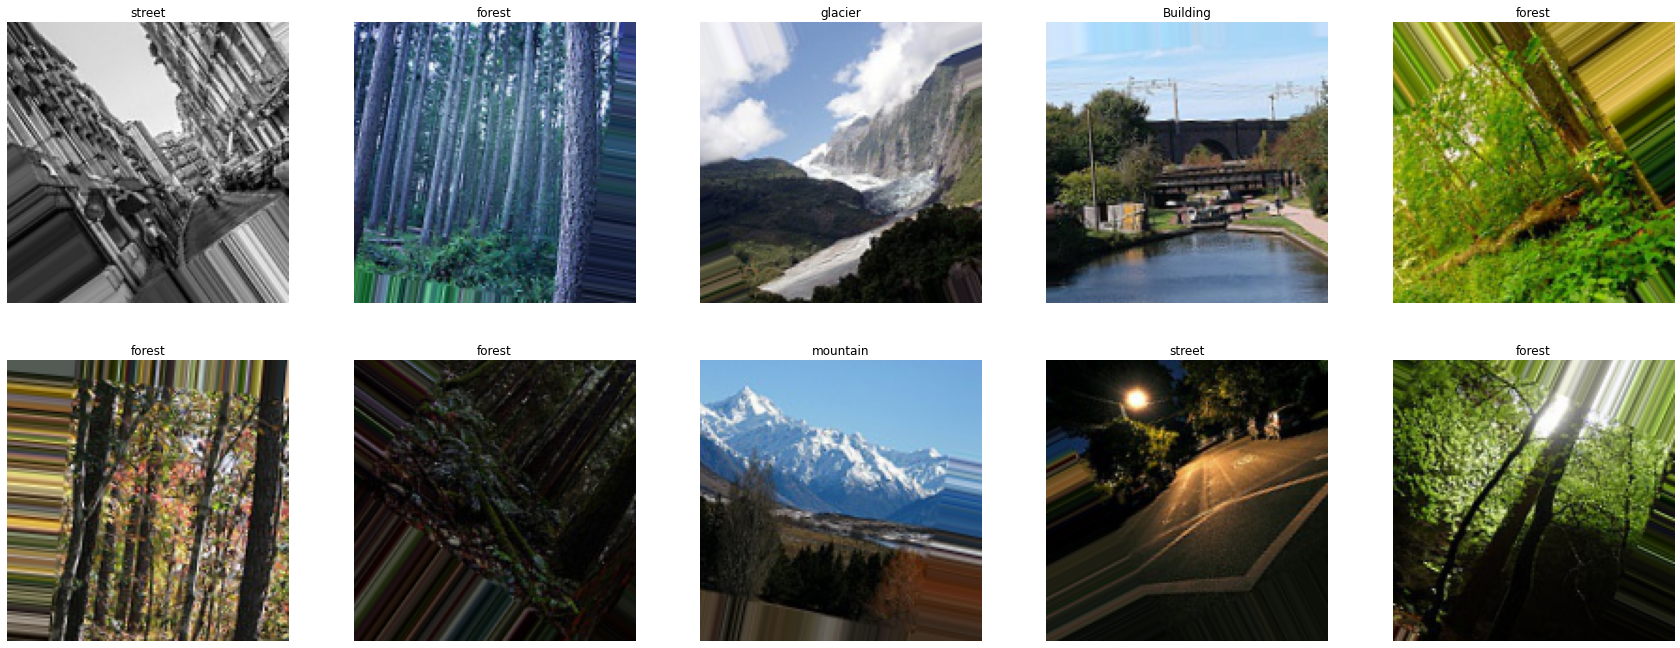

In [ ]:
plt.figure(figsize=(30,30))
for n , i in enumerate(list(np.random.randint(0,len(images),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(images[i] , cmap='gray')
    plt.title(class_label(labels[i]))
    plt.axis('off')     
plt.show()

## loading Pretrained Inception Model

In [ ]:
incepmodel = InceptionV3(include_top= False, input_shape=(150,150,3))

## Creating Model

In [ ]:
## Removing Old Dense Layers for output
for layer in incepmodel.layers:
    layer.trainable = False

layer = incepmodel.get_layer('mixed9')
output = layer.output

In [ ]:
lay = layers.Flatten()(output)
lay = layers.Dense(units = 1024, activation = tf.nn.relu)(lay)
lay = layers.Dropout(0.2)(lay)
lay = layers.Dense  (6, activation = 'softmax')(lay)

model = tf.keras.Model(incepmodel.input, lay)

## Model Summary

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Model Compile

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=1,
                                            verbose=1,
                                            factor=0.25,
                                            min_lr=0.000003)

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(), metrics=['acc'])

## Train Model

In [ ]:
history = model.fit(X_train,
                    epochs = 10,
                    verbose = 1,
                   validation_data = X_test,
                   callbacks=[learning_rate_reduction])

Epoch 1/10
439/439 [==============================] - 124s 276ms/step - loss: 0.4528 - acc: 0.8430 - val_loss: 0.3060 - val_acc: 0.8827 - lr: 0.0010
Epoch 2/10
439/439 [==============================] - 88s 201ms/step - loss: 0.3623 - acc: 0.8672 - val_loss: 0.3045 - val_acc: 0.8853 - lr: 0.0010
Epoch 3/10
439/439 [==============================] - 90s 204ms/step - loss: 0.3243 - acc: 0.8794 - val_loss: 0.2709 - val_acc: 0.9023 - lr: 0.0010
Epoch 4/10
439/439 [==============================] - ETA: 0s - loss: 0.3147 - acc: 0.8828
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
439/439 [==============================] - 89s 203ms/step - loss: 0.3147 - acc: 0.8828 - val_loss: 0.2744 - val_acc: 0.8990 - lr: 0.0010
Epoch 5/10
439/439 [==============================] - 90s 205ms/step - loss: 0.2522 - acc: 0.9077 - val_loss: 0.2404 - val_acc: 0.9083 - lr: 2.5000e-04
Epoch 6/10
439/439 [==============================] - 88s 200ms/step - loss: 0.2459 - acc: 0.9074 -

## Model Graphs

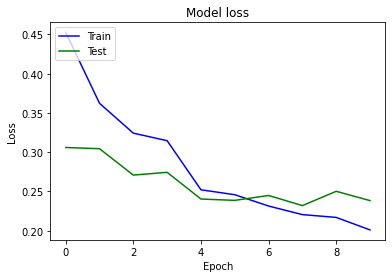

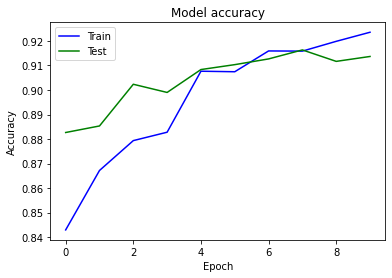

In [ ]:
# Loss Plot
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'g')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Accuracy Plot
plt.plot(history.history['acc'],'b')
plt.plot(history.history['val_acc'],'g')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save Model

In [ ]:
model.save("model.h5")

## Prediction

In [ ]:
## Evaulating Test Data
loss , accuracy = model.evaluate(X_test)
print("Accuracy of model:", accuracy*100)

1/1 [==============================] - 5s 5s/step - loss: 0.2384 - acc: 0.9137
Accuracy of model: 91.36666655540466


## Prediction

In [ ]:
## Prediction
testimages,true_labels = next(X_test)
predictions = model.predict(testimages)

In [ ]:
# Get most likely class
predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))

## Ground Truth

In [ ]:
# Get most likely class
true_labels = np.array(list(map(lambda x: np.argmax(x), true_labels)))
class_labels = list(train_data_generator.class_indices.keys())   

## Confusion Matrix

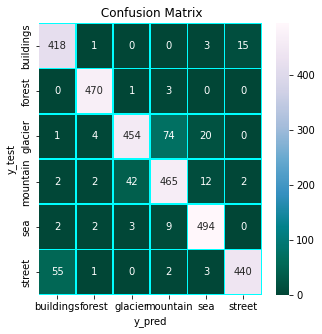

In [ ]:
# Creating the confusion matrix:
cm = confusion_matrix(true_labels, predictions)

# Visualization:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='PuBuGn_r')
plt.title(' Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.show()

## Confusion Matrix

In [ ]:
report = classification_report(true_labels, predictions, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

   buildings       0.87      0.96      0.91       437
      forest       0.98      0.99      0.99       474
     glacier       0.91      0.82      0.86       553
    mountain       0.84      0.89      0.86       525
         sea       0.93      0.97      0.95       510
      street       0.96      0.88      0.92       501

    accuracy                           0.91      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.91      0.91      3000



## Prediction

In [ ]:
label = model.predict(testimages)
label = np.argmax(label, axis=1)

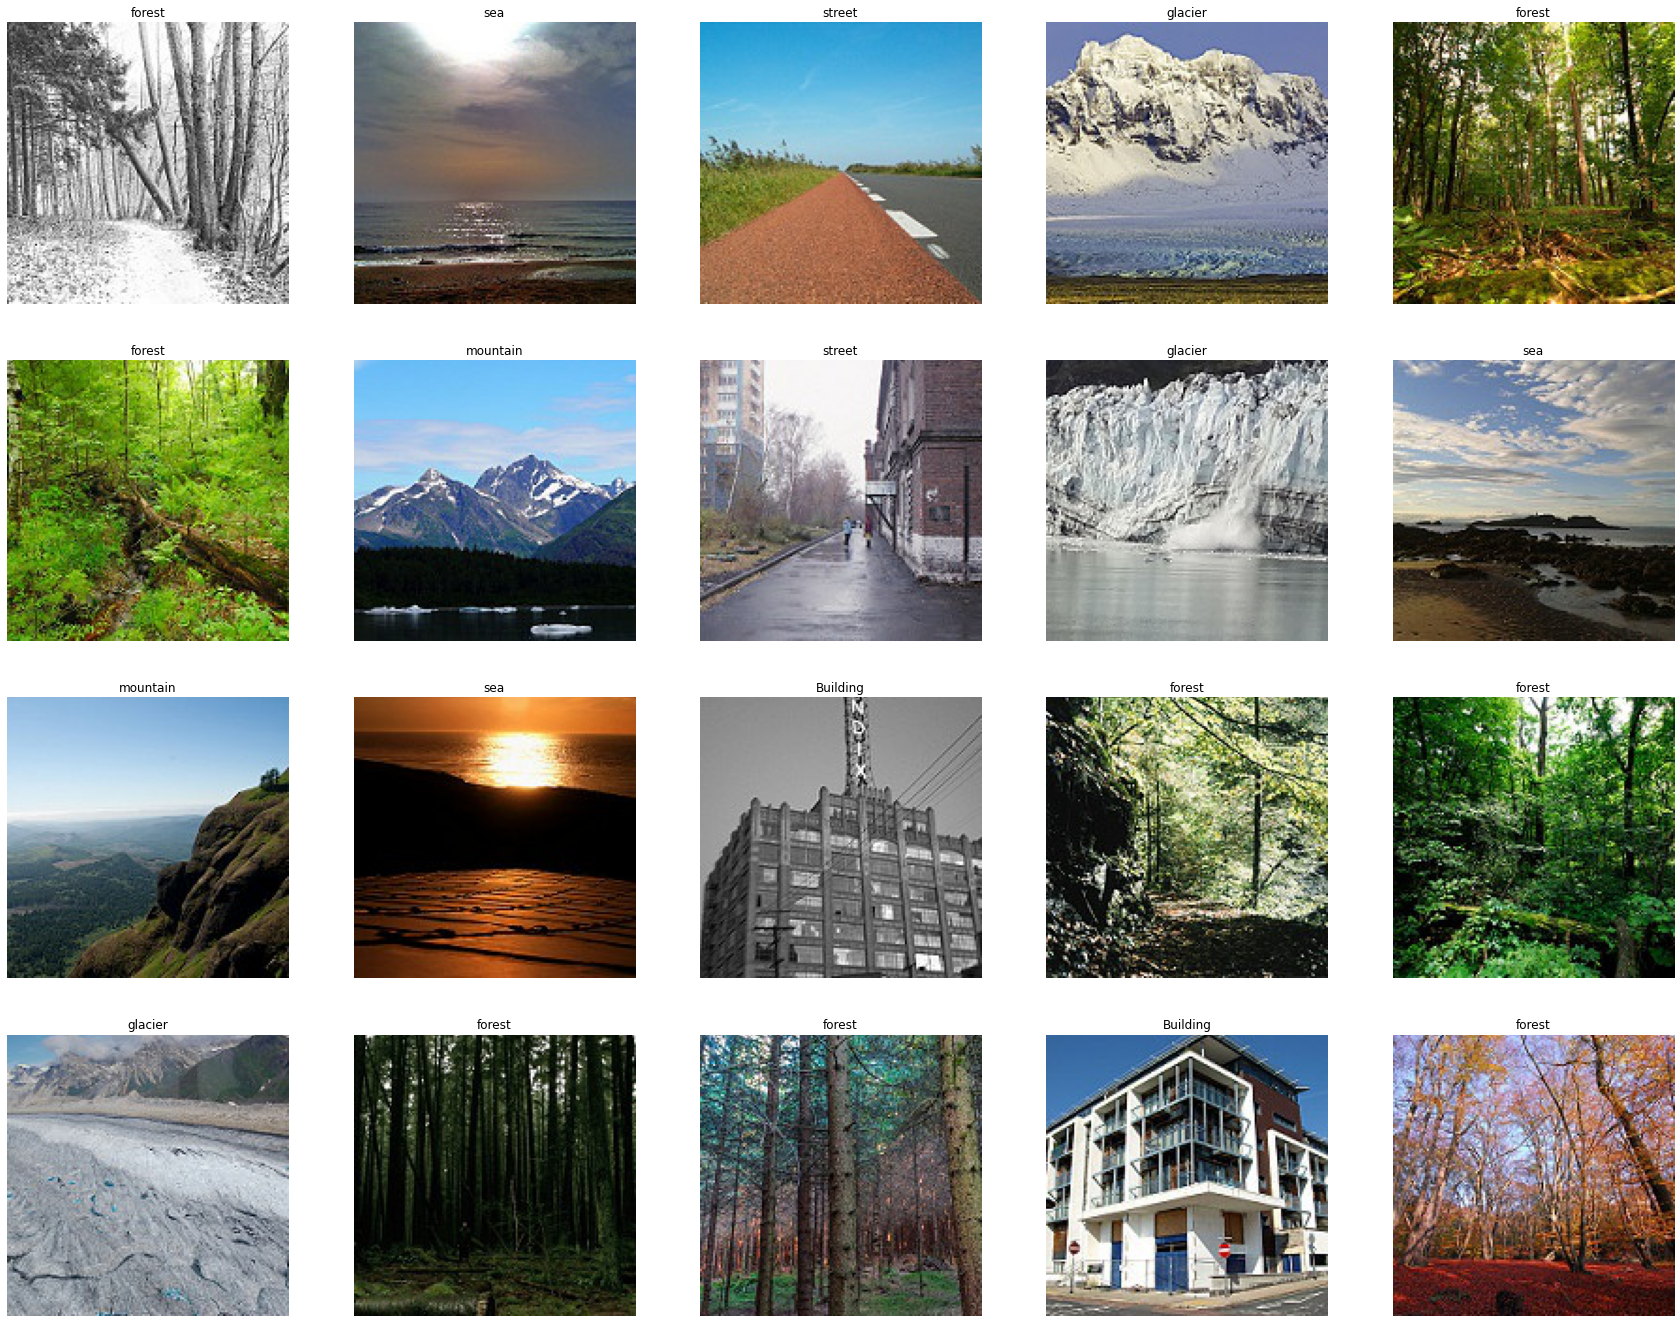

In [ ]:
plt.figure(figsize=(30,30))
for n , i in enumerate(list(np.random.randint(0,len(testimages),20))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(testimages[i] , cmap='gray')
    plt.title(class_label(label[i]))
    plt.axis('off')     
plt.show()

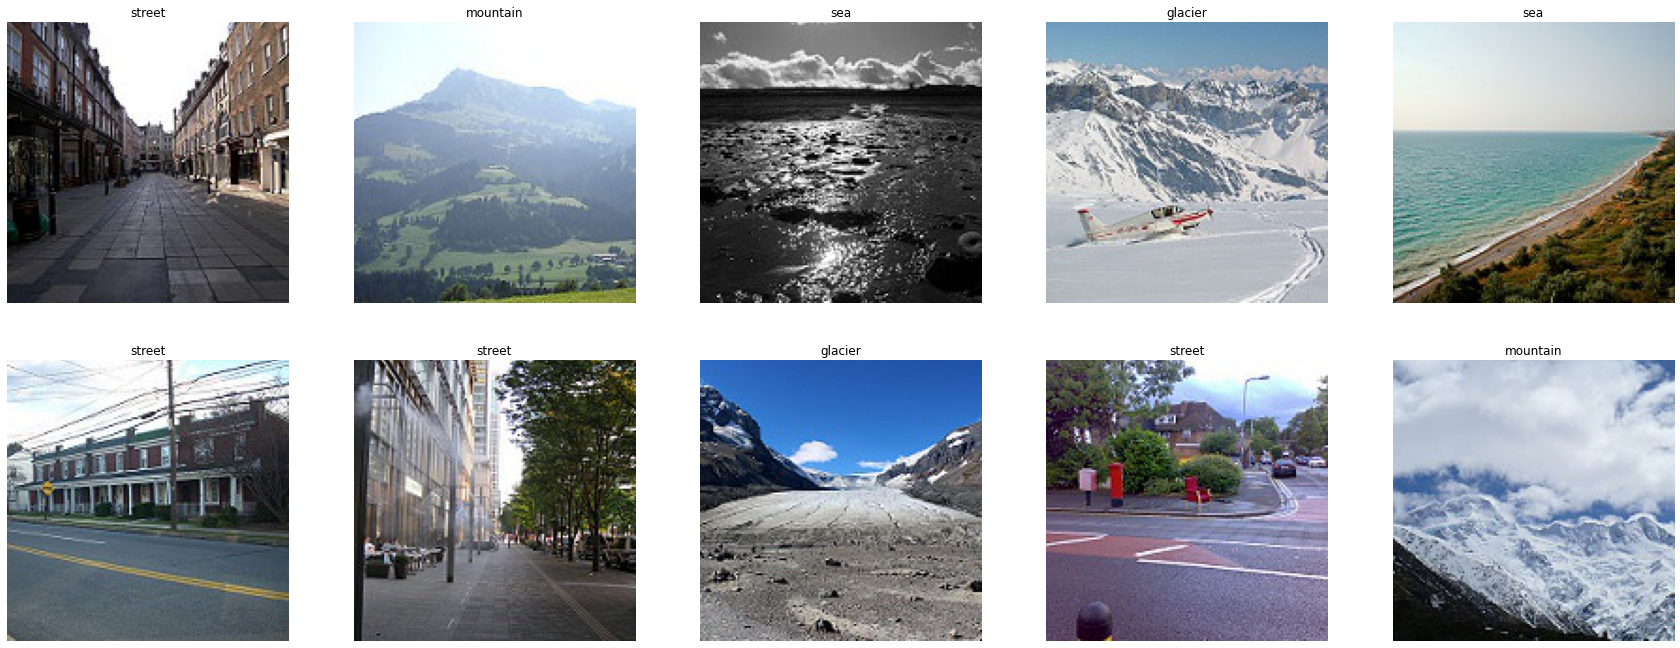

In [ ]:
plt.figure(figsize=(30,30))
for n , i in enumerate(list(np.random.randint(0,len(testimages),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(testimages[i] , cmap='gray')
    plt.title(class_label(label[i]))
    plt.axis('off')     
plt.show()